# Download Resources

### This will need to be executed on JupyterHub and Google Colab (http://colab.research.google.com) only.

In [ ]:
!git clone https://github.com/Harvard-IACS/2019-computefest.git

In [ ]:
import os
os.chdir("2019-computefest/Wednesday/auto_encoder")

In [ ]:
!ls

## 1. Imports

We will import both Keras and the Tensorflow backend. In addition, some common libraries are used for I/O, image and data processing, and visualization.

In [ ]:
import keras
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Dense, Lambda, Flatten
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import skimage
import PIL
import numpy as np
import os
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio
import utils

## 2. Definitions

The major definition here will be our network architecture for the VAE. It follows an encoder-decoder architecture.

In [2]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

In [3]:
def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define three sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

In [4]:
def define_net(variational, height, width, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, 3))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
    
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv2D(3, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
    
    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

Next, we define some functions to make encoding and decoding easier.

In [5]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    '''Encodes an image that is given in RGB-channel order with value range of [0, 255].
    
    Args:
        img: The image input. If shapes differ from (height, width), it will be resized.
        conditoning: The set of values to condition on, if any. Can be None.
        encoder: The keras encoder model to use.
        height: The target image height.
        width: The target image width.
        batch_size: The batchsize that the encoder expects.
        
    Returns:
        The latent representation of the input image.
    '''
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width)) #cv2.resize(img, (width, height))
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32) / 255.
    img_single = np.repeat(img_single, batch_size, axis=0)
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

In [6]:
def decode_embedding(z, conditioning, decoder):
    '''Decodes the given representation into an image.
    
    Args:
        z: The latent representation.
        conditioning: The set of values to condition on, if any. Can be None.
        decoder: The keras decoder model to use.
    '''
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0) # Single-batch
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

In [7]:
def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')

## Prepare MNIST data

Next, we prepare the MNIST data by downsampling it and scaling the intensity ranges. Note that we could have also used binary crossentropy loss here, as MNIST is often used in binarized form. However, we treat the intensity values as floats.

In [8]:
x_train, y_train, x_test, y_test = utils.load_mnist(target_height=32, target_width=32)
# We work on a subset here, to make training on CPU's feasible.
indices_train = np.random.choice(list(range(x_train.shape[0])), size=30000, replace=False)
x_train = x_train[indices_train]
y_train = y_train[indices_train]
indices_test = np.random.choice(list(range(x_test.shape[0])), size=2000, replace=False)
x_test = x_test[indices_test]
y_test = y_test[indices_test]

details: shape (60000, 32, 32, 3) min 0.0 max 1.0
details: shape (10000, 32, 32, 3) min 0.0 max 1.0


In [9]:
x_train[0].max()

0.9918352

## 3. Unconditional AE: Application to MNIST

First, we define the autoencoder using the definitions above, then we train it for a single epoch:

In [10]:
vae, encoder, decoder = define_net(
    False, 32, 32, batch_size=8, latent_dim=2, start_filters=8)

done, 185173 parameters.


In [ ]:
vae.fit(x_train, x_train, batch_size=8, verbose=1, epochs=10)

Alternatively, we can load pre-trained weights.

In [11]:
load_weights(folder='models/mnist_ae')

In [12]:
# save_weights(folder='models/mnist_ae')

Below, we plot the latent representation of all the MNIST test images and their groundtruth label. As we can see, the clusters are already grouped together quite nicely.

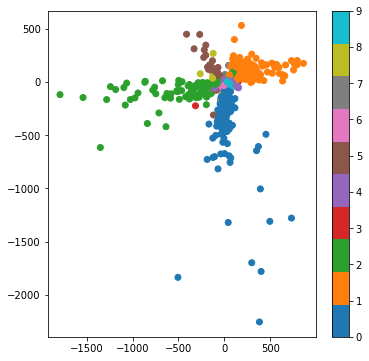

In [15]:
x_test_encoded = encoder.predict(x_test, batch_size=8)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.show()

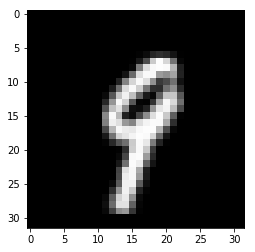

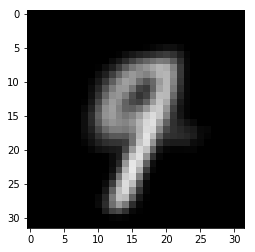

In [16]:
x_demo = x_test[np.random.randint(x_test.shape[0])]
pred = vae.predict(np.expand_dims(x_demo, axis=0))
plt.imshow(x_demo)
plt.show()
plt.imshow(pred[0])

## 4. Unconditional VAE: Application to MNIST

First, we define the VAE network using the definitions above, then we train it for a single epoch:

In [17]:
vae, encoder, decoder = define_net(
    True, 32, 32, batch_size=8, latent_dim=2, start_filters=4)

done, 47055 parameters.


In [ ]:
vae.fit(x_train, x_train, batch_size=8, verbose=1, epochs=50)

Alternatively, we can load pre-trained weights.

In [18]:
load_weights(folder='models/mnist_vae')

In [19]:
# save_weights(folder='models/mnist_vae')

After just one epoch, we already get promising results. Below, we plot the latent representation of all the MNIST test images and their groundtruth label. As we can see, the clusters are already grouped together quite nicely.

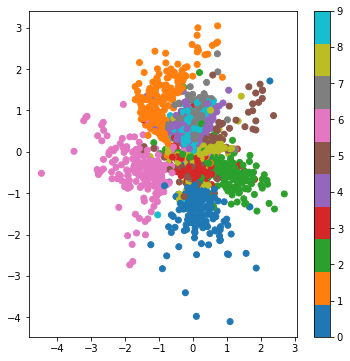

In [20]:
x_test_encoded = encoder.predict(x_test, batch_size=8)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.show()

We also render parts of the manifold by varying the latent representation.

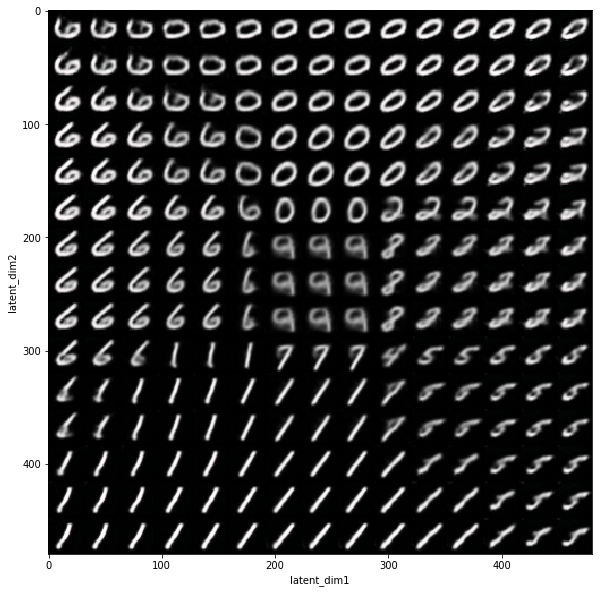

In [21]:
_ = utils.display_manifold(decoder,
                           32,
                           32,
                           bound_x=5,
                           bound_y=5,
                           base_vec=np.array([0,0]),
                           desc_x='latent_dim1',
                           desc_y='latent_dim2',
                           file_out='rendering_mnist.png')

## 5. Conditional VAE: Application to CelebA

For the face dataset CelebA, we will use a conditional VAE. We first define the hyperparameters to use for this experiment.

In [22]:
VARIATIONAL = True
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 16
LATENT_DIM = 16
START_FILTERS = 32
CONDITIONING = True

Since this is a large dataset, we also define a custom data generator to avoid caching the whole set in memory.

In [23]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, files, batch_size, target_height, target_width, conditioning_dim=0, conditioning_data=None):
        '''
        Intializes the custom generator.
        
        Args:
            files: The list of paths to images that should be fed to the network.
            batch_size: The batchsize to use.
            target_height: The target image height. If different, the images will be resized.
            target_width: The target image width. If different, the images will be resized.
            conditioning_dim: The dimension of the conditional variable space. Can be 0.
            conditioning_data: Optional dictionary that maps from the filename to the data to be
                conditioned on. Data must be numeric. Can be None. Otherwise, len must be equal to
                conditioning_dim.
        '''
        self.files = files
        self.batch_size = batch_size
        self.target_height = target_height
        self.target_width = target_width
        self.conditioning_dim = conditioning_dim
        self.conditioning_data = conditioning_data

    def on_epoch_end(self):
        '''Shuffle list of files after each epoch.'''
        np.random.shuffle(self.files)
        
    def __getitem__(self, index):
        cur_files = self.files[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(cur_files)
        return X, y
    
    def __data_generation(self, cur_files):
        X = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        Y = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        if self.conditioning_data != None:
            C = np.empty(shape=(self.batch_size, self.conditioning_dim))
        
        for i, file in enumerate(cur_files):
            img = skimage.io.imread(file)
            if img.shape[0] != self.target_height or img.shape[1] != self.target_width:
                img = skimage.transform.resize(img, (self.target_height, self.target_width)) # Resize.
            img = img.astype(np.float32) #/ 255. # Scale values.
            X[i] = img
            Y[i] = img
            if self.conditioning_data != None:
                C[i] = self.conditioning_data[os.path.basename(file)]
                
        if self.conditioning_data != None:
            return [X, C], Y
        else:
            return X, Y
    
    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

We will read the annotation data now.

In [24]:
# Find image files.
files = glob.glob('celeba/img_align_celeba/*.jpg')
print(len(files), 'images found.')

df = utils.load_celeba('celeba/list_attr_celeba.txt')
columns = df.columns
df.head(3)

202599 images found.


,Filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1


We convert the dataframe into a dictionary, mapping from filename to the individual image attributes. We then instantiate the generator.

In [25]:
dd = {}
selected_conditionals = list(columns[1:])
for i, row in df.iterrows():
    dd[row['Filename']] = [int(row[c]) for c in selected_conditionals]

gen = CustomDataGenerator(files=files, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=len(selected_conditionals),
                          conditioning_data=dd if CONDITIONING else None)

Finally, we define the conditional VAE and start the training.

In [26]:
vae, encoder, decoder = define_net(variational=VARIATIONAL,
                                   height=HEIGHT, 
                                   width=WIDTH, 
                                   batch_size=BATCH_SIZE, 
                                   latent_dim=LATENT_DIM,
                                   conditioning_dim=len(selected_conditionals) if CONDITIONING else 0, 
                                   start_filters=START_FILTERS)

done, 5063811 parameters.


In [ ]:
# vae.fit_generator(gen, verbose=1, epochs=20)

Alternatively, we can load pre-trained weights:

In [27]:
load_weights(folder='models/celeba_vae')

In [28]:
# save_weights(folder='models/celeba_vae')

Let's look at some examples. First, we will select a random image from the CelebA dataset, and read the related annotation data.

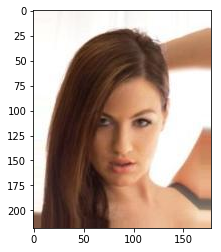

image meta data: [-1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1]


In [42]:
rnd_file = np.random.choice(files)
file_id = os.path.basename(rnd_file)
meta = dd[file_id]

img = skimage.io.imread(rnd_file)
plt.imshow(img)
plt.show()
print('image meta data:', meta)

Now, we will encode the image into its latent representation.

In [43]:
z = encode_image(img.astype(np.float32), np.array(meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

latent sample:
 [ 1.0472881 -0.5055443 -2.314043   1.0798056  1.849553   1.9363003
  1.0128627 -2.953055   1.1264266  3.2040517 -1.6549879 -2.6976933
  0.7443421  1.4470778  4.2862935  3.6141446]


Decoding the latent representation should result in a face with somewhat similar characterics.

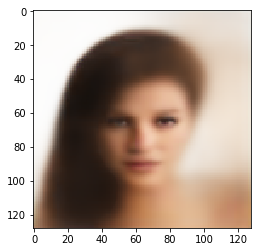

In [44]:
ret = decode_embedding(z, meta, decoder)
plt.imshow(ret[0])
plt.show()

The next step is interesting: We can manipulate the embedding to change the facial structure. We can modify both our conditionals, as well as the latent variables. Here, we plot sliders to make the process interactive.

In [45]:
def render(**params):
    perturb_latent = np.zeros(shape=(LATENT_DIM))
    for i in range(LATENT_DIM):
        perturb_latent[i] = params['latent' + str(i)]

    c = []
    for k,v in params.items():
        if not k.startswith('latent'):
            c.append(v)
    ret = decode_embedding(z[0] + perturb_latent, conditioning=np.array(c), decoder=decoder)[0]
    ret = np.clip(ret, 0, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(ret)

In [46]:
# Note: Interactive widgets (i.e. this cell) will not work in Colab.

lower, upper = -10, 10
params = {}
for i, c in enumerate(selected_conditionals):
    params[c] = widgets.FloatSlider(min=lower,max=upper,step=0.1,value=meta[i], layout=widgets.Layout(width='70%', height='20px'))
for c in ['latent' + str(i) for i in range(LATENT_DIM)]:
    params[c] = widgets.FloatSlider(min=lower,max=upper,step=0.1,value=0,layout=widgets.Layout(width='70%', height='20px'))
    
interactive_plot = interactive(render, **params)
output = interactive_plot.children[-1]
output.layout.height = '200px'
interactive_plot

interactive(children=(FloatSlider(value=-1.0, description='5_o_Clock_Shadow', layout=Layout(height='20px', wid…

Similar to our MNIST example, we can also visualize a grid of samples by just manipulating two of the dimensions.

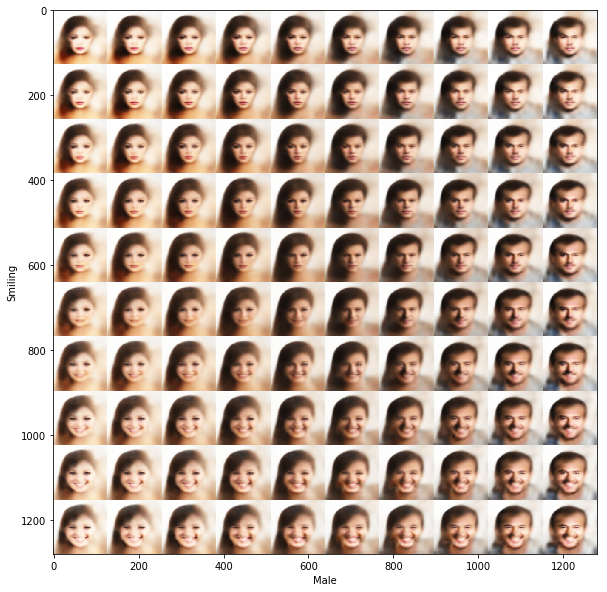

In [47]:
dim1 = 'Male'
dim2 = 'Smiling'
base_vec = np.array(list(z[0]) + meta)
rendering, _ = utils.display_manifold(
    decoder, 
    HEIGHT, 
    WIDTH, 
    base_vec, 
    bound_x=15, 
    bound_y=15, 
    axis_x=LATENT_DIM + selected_conditionals.index(dim1), 
    axis_y=LATENT_DIM + selected_conditionals.index(dim2), 
    n=10,
    desc_x = dim1,
    desc_y = dim2,
    file_out = 'rendering_celeba_' + dim1.lower() + '_' + dim2.lower() + '.png')

Additionally, we can create image sequences when manipulating a certain dimension. We save the result as an animated GIF.

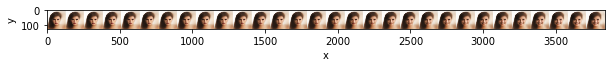

In [48]:
dim = 'Smiling'
utils.generate_gif(decoder, 
                   height=HEIGHT, 
                   width=WIDTH,
                   base_vec=np.array(list(base_vec)), 
                   axis=LATENT_DIM + selected_conditionals.index(dim),
                   total_frames=30,
                   degree=5,
                   file_out='animation_' + dim.lower() + '.gif')

## 6. Discussion

A common problem of variational autoencoders is their tendency to produce blurry, non-photorealistic outputs. We can observe the same behaviour, especially on natural images (CelebA). GANs, with their explicit formulation of a discriminator network that learns to differentiate what is photorealistic to humans and what is not, tend to produce even nicer-looking results.

If we wanted to use this model to change the characteristics of a particular face based on a photo, we would have to either: 
(1) estimate all the conditional variables ourselves to feed them into the encoder and decoder, or
(2) change the model formulation such that the encoder simultaneously predicts conditional attributes such as gender and age.

With the current formulation, however, we can already nicely synthesize specific faces, and customize them to fit our needs.